In [11]:
import h5py

with h5py.File('data.h5', 'r') as hf:
    input_data = hf['input_data'][:]  # type: ignore[index]
    output_data = hf['output_data'][:]  # type: ignore[index]


In [50]:
import torch
from torch.utils.data import random_split, TensorDataset
import numpy as np

# Assuming input_data and output_data are numpy arrays
# Convert numpy arrays to PyTorch tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32)
output_tensor = torch.tensor(output_data, dtype=torch.float32)

# Create a combined dataset
dataset = TensorDataset(input_tensor, output_tensor[:,2][:,None]/np.mean(output_data[:,2]))

# Define the sizes for training and testing datasets
train_size = int(0.001 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into training and testing datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Get the X and y for training and testing
X_train = train_dataset[:][0]
y_train = train_dataset[:][1]
X_test = test_dataset[:][0]
y_test = test_dataset[:][1]

print(f"Size of training dataset: {len(train_dataset)}")
print(f"Size of testing dataset: {len(test_dataset)}")


Size of training dataset: 151
Size of testing dataset: 151080


In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

n_lyer = 20
# Step 1: Define the Neural Network Architecture


class MLPRegressor(nn.Module):
    def __init__(self):
        super(MLPRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], n_lyer),
            nn.Tanh(),
            nn.Linear(n_lyer, n_lyer),
            nn.Tanh(),
            nn.Linear(n_lyer, n_lyer),
            nn.Tanh(),
            nn.Linear(n_lyer, y_train.shape[1])
        )

    def forward(self, x):
        return self.layers(x)


# Step 2: Move the Model to GPU if Available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
model = MLPRegressor().to(device)

# Step 3: Define a Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, factor=0.75)

# Step 4: Convert Numpy Data to PyTorch Tensors and Move to Device
X_train_tensor = X_train.clone().detach().to(device).float()
X_test_tensor = X_test.clone().detach().to(device).float()
y_train_tensor = y_train.clone().detach().to(device).float()
y_test_tensor = y_test.clone().detach().to(device).float()

loss_train = []
loss_test = []
# Step 5: Train the Model
max_iter = 200000
for iteration in range(max_iter):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)


    if iteration % 100 == 0:
        print(f'Iteration {iteration}, Loss: {loss.item()}, Learning rate: {optimizer.param_groups[0]["lr"]}.')
        loss_train.append(loss.item())
        loss_test.append(criterion(model(X_test_tensor), y_test_tensor).item())
        if loss.item() < 1e-6:
            break
        if optimizer.param_groups[0]["lr"] < 1e-8:
            break



Using cuda device
Iteration 0, Loss: 1.5550994873046875, Learning rate: 0.1.
Iteration 100, Loss: 0.07294974476099014, Learning rate: 0.1.
Iteration 200, Loss: 0.00617704214528203, Learning rate: 0.1.
Iteration 300, Loss: 0.01925477385520935, Learning rate: 0.1.
Iteration 400, Loss: 0.0032977480441331863, Learning rate: 0.1.
Iteration 500, Loss: 0.00036370044108480215, Learning rate: 0.1.
Iteration 600, Loss: 0.0030000375118106604, Learning rate: 0.1.
Iteration 700, Loss: 0.0017421285156160593, Learning rate: 0.1.
Iteration 800, Loss: 0.0001276275288546458, Learning rate: 0.1.
Iteration 900, Loss: 0.0005222893669269979, Learning rate: 0.1.
Iteration 1000, Loss: 8.36309336591512e-05, Learning rate: 0.1.
Iteration 1100, Loss: 3.8388901884900406e-05, Learning rate: 0.1.
Iteration 1200, Loss: 3.6231413105269894e-05, Learning rate: 0.1.
Iteration 1300, Loss: 4.446534512680955e-05, Learning rate: 0.1.
Iteration 1400, Loss: 0.00010518804629100487, Learning rate: 0.1.
Iteration 1500, Loss: 1.3

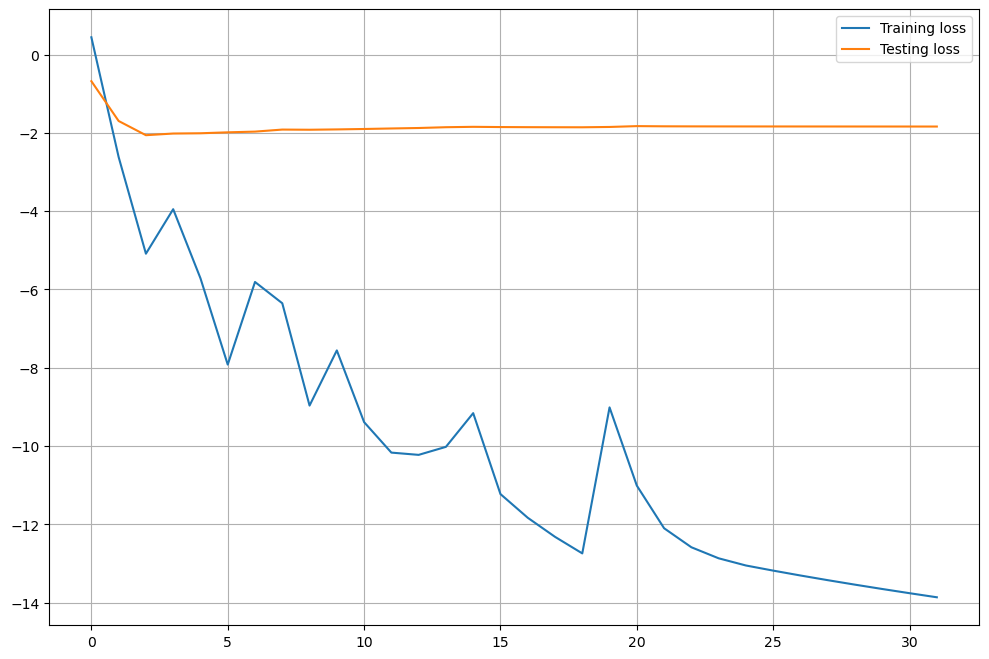

In [52]:
# plot loss_train and loss_test in log scale
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(np.log(loss_train), label='Training loss')
plt.plot(np.log(loss_test), label='Testing loss')
# add grid
plt.grid()
plt.legend()

In [92]:
import torch
from torch.utils.data import random_split, TensorDataset

# Assuming input_data and output_data are numpy arrays
# Convert numpy arrays to PyTorch tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32)
output_tensor = torch.tensor(output_data, dtype=torch.float32)

# Create a combined dataset
dataset = TensorDataset(input_tensor, output_tensor)

# Define the sizes for training and testing datasets
train_size = int(0.01 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into training and testing datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Get the X and y for training and testing
X_train = train_dataset[:][0]
y_train = train_dataset[:][1]
X_test = test_dataset[:][0]
y_test = test_dataset[:][1]

print(f"Size of training dataset: {len(train_dataset)}")
print(f"Size of testing dataset: {len(test_dataset)}")


Size of training dataset: 1512
Size of testing dataset: 149719


In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

n_lyer = 10
# Step 1: Define the Neural Network Architecture


class MLPRegressor(nn.Module):
    def __init__(self):
        super(MLPRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], n_lyer),
            nn.Tanh(),
            nn.Linear(n_lyer, n_lyer),
            nn.Tanh(),
            nn.Linear(n_lyer, n_lyer),
            nn.Tanh(),
            nn.Linear(n_lyer, y_train.shape[1])
        )

    def forward(self, x):
        return self.layers(x)


# Step 2: Move the Model to GPU if Available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
model = MLPRegressor().to(device)

# Step 3: Define a Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, factor=0.5)

# Step 4: Convert Numpy Data to PyTorch Tensors and Move to Device
X_train_tensor = X_train.clone().detach().to(device).float()
X_test_tensor = X_test.clone().detach().to(device).float()
y_train_tensor = y_train.clone().detach().to(device).float()
y_test_tensor = y_test.clone().detach().to(device).float()

loss_train = []
loss_test = []
# Step 5: Train the Model
max_iter = 200000
for iteration in range(max_iter):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)


    if iteration % 100 == 0:
        print(f'Iteration {iteration}, Loss: {loss.item()}, Learning rate: {optimizer.param_groups[0]["lr"]}.')
        loss_train.append(loss.item())
        loss_test.append(criterion(model(X_test_tensor), y_test_tensor).item())



Using cuda device
Iteration 0, Loss: 8964.591796875, Learning rate: 0.001.
Iteration 100, Loss: 8766.875, Learning rate: 0.001.
Iteration 200, Loss: 8501.9833984375, Learning rate: 0.001.
Iteration 300, Loss: 8294.9384765625, Learning rate: 0.001.
Iteration 400, Loss: 8106.15673828125, Learning rate: 0.001.
Iteration 500, Loss: 7927.35498046875, Learning rate: 0.001.
Iteration 600, Loss: 7755.59814453125, Learning rate: 0.001.
Iteration 700, Loss: 7589.46142578125, Learning rate: 0.001.
Iteration 800, Loss: 7428.125, Learning rate: 0.001.
Iteration 900, Loss: 7271.0625, Learning rate: 0.001.
Iteration 1000, Loss: 7117.90673828125, Learning rate: 0.001.
Iteration 1100, Loss: 6968.38623046875, Learning rate: 0.001.
Iteration 1200, Loss: 6822.2919921875, Learning rate: 0.001.
Iteration 1300, Loss: 6679.45166015625, Learning rate: 0.001.
Iteration 1400, Loss: 6539.72607421875, Learning rate: 0.001.
Iteration 1500, Loss: 6402.99462890625, Learning rate: 0.001.
Iteration 1600, Loss: 6269.153

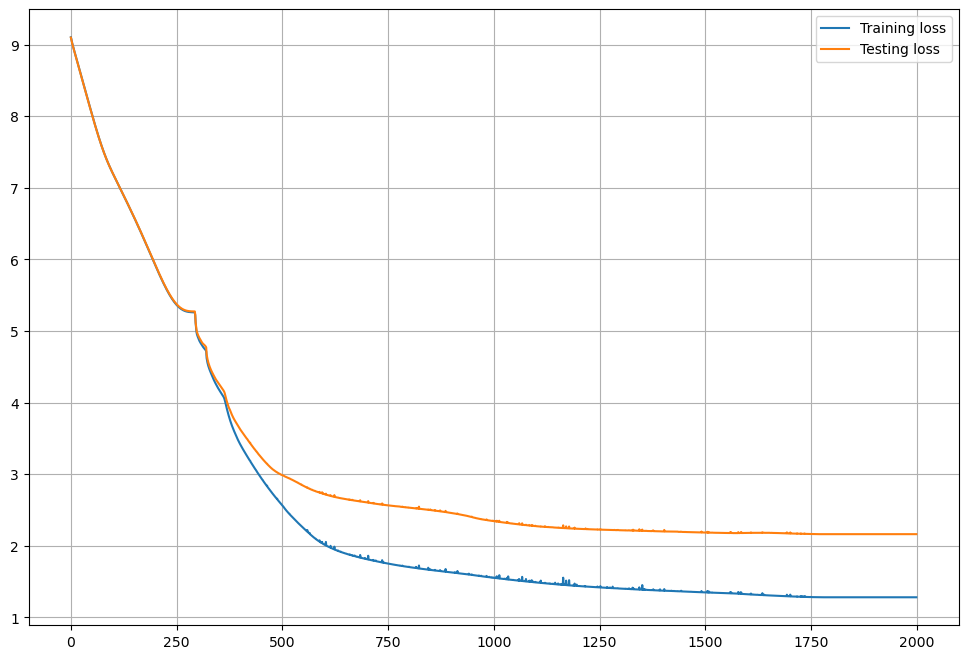

In [109]:
# plot loss_train and loss_test in log scale
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(np.log(loss_train), label='Training loss')
plt.plot(np.log(loss_test), label='Testing loss')
# add grid
plt.grid()
plt.legend()

In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

n_lyer = 100
# Step 1: Define the Neural Network Architecture


class MLPRegressor(nn.Module):
    def __init__(self):
        super(MLPRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], n_lyer),
            nn.Tanh(),
            nn.Linear(n_lyer, n_lyer),
            nn.Tanh(),
            nn.Linear(n_lyer, y_train.shape[1])
        )

    def forward(self, x):
        return self.layers(x)


# Step 2: Move the Model to GPU if Available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
model = MLPRegressor().to(device)

# Step 3: Define a Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, factor=0.5)

# Step 4: Convert Numpy Data to PyTorch Tensors and Move to Device
X_train_tensor = X_train.clone().detach().to(device).float()
X_test_tensor = X_test.clone().detach().to(device).float()
y_train_tensor = y_train.clone().detach().to(device).float()
y_test_tensor = y_test.clone().detach().to(device).float()

loss_train = []
loss_test = []
# Step 5: Train the Model
max_iter = 200000
for iteration in range(max_iter):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)


    if iteration % 100 == 0:
        print(f'Iteration {iteration}, Loss: {loss.item()}, Learning rate: {optimizer.param_groups[0]["lr"]}.')
        loss_train.append(loss.item())
        loss_test.append(criterion(model(X_test_tensor), y_test_tensor).item())



Using cuda device
Iteration 0, Loss: 8966.685546875, Learning rate: 0.0001.
Iteration 100, Loss: 8888.43359375, Learning rate: 0.0001.
Iteration 200, Loss: 8690.6435546875, Learning rate: 0.0001.
Iteration 300, Loss: 8393.8125, Learning rate: 0.0001.
Iteration 400, Loss: 8094.0029296875, Learning rate: 0.0001.
Iteration 500, Loss: 7831.8017578125, Learning rate: 0.0001.
Iteration 600, Loss: 7605.36962890625, Learning rate: 0.0001.
Iteration 700, Loss: 7404.0693359375, Learning rate: 0.0001.
Iteration 800, Loss: 7220.279296875, Learning rate: 0.0001.
Iteration 900, Loss: 7049.2490234375, Learning rate: 0.0001.
Iteration 1000, Loss: 6887.9814453125, Learning rate: 0.0001.
Iteration 1100, Loss: 6734.5185546875, Learning rate: 0.0001.
Iteration 1200, Loss: 6587.52392578125, Learning rate: 0.0001.
Iteration 1300, Loss: 6446.04833984375, Learning rate: 0.0001.
Iteration 1400, Loss: 6309.39501953125, Learning rate: 0.0001.
Iteration 1500, Loss: 6177.037109375, Learning rate: 0.0001.
Iteration

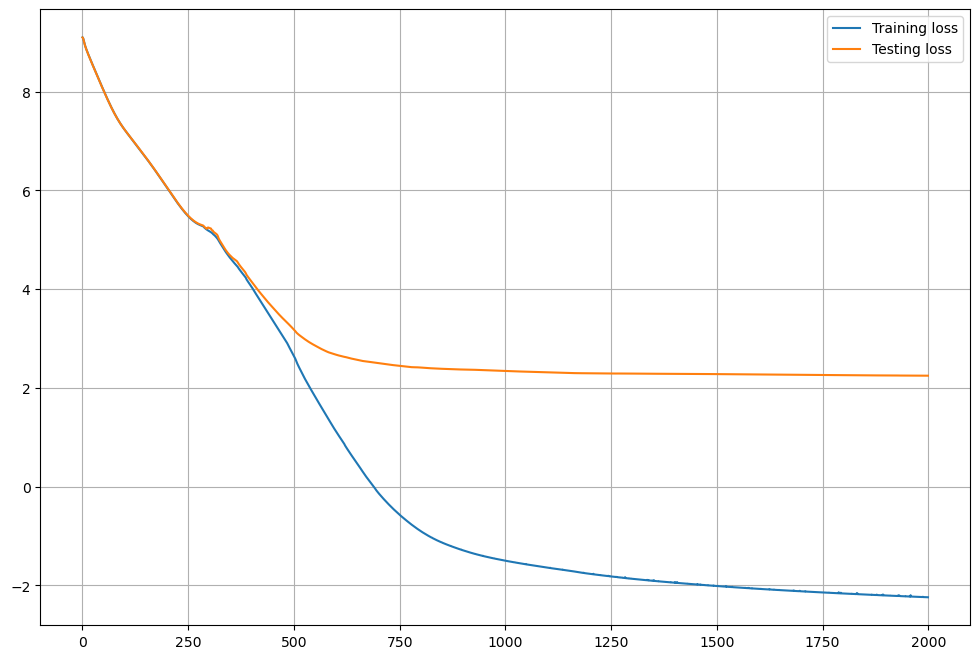

In [112]:
# plot loss_train and loss_test in log scale
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(np.log(loss_train), label='Training loss')
plt.plot(np.log(loss_test), label='Testing loss')
# add grid
plt.grid()
plt.legend()

In [90]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# Create dataset and dataloader
batch_size = 64
dataset = CustomDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Step 3: Define a Loss Function and Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2 * len(dataloader), factor=0.85)
# Train the model with mini-batch training
max_epochs = 2000

loss_train_fine = []
loss_test_fine = []

for epoch in range(max_epochs):
    loss_max = 0
    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        loss_max = max(loss_max, loss.item())

    loss_train_fine.append(criterion(model(X_train_tensor), y_train_tensor).item())
    loss_test_fine.append(criterion(model(X_test_tensor), y_test_tensor).item())
    print(f'Epoch {epoch}, Loss: {loss_max},  Learning rate: {optimizer.param_groups[0]["lr"]}')

Epoch 0, Loss: 0.02030201442539692,  Learning rate: 1e-05
Epoch 1, Loss: 0.01797362044453621,  Learning rate: 1e-05
Epoch 2, Loss: 0.016204314306378365,  Learning rate: 8.5e-06
Epoch 3, Loss: 0.01924838125705719,  Learning rate: 8.5e-06
Epoch 4, Loss: 0.02072378806769848,  Learning rate: 7.2249999999999994e-06
Epoch 5, Loss: 0.017878595739603043,  Learning rate: 7.2249999999999994e-06
Epoch 6, Loss: 0.01982666552066803,  Learning rate: 7.2249999999999994e-06
Epoch 7, Loss: 0.01923871971666813,  Learning rate: 7.2249999999999994e-06
Epoch 8, Loss: 0.015699252486228943,  Learning rate: 6.141249999999999e-06
Epoch 9, Loss: 0.018366334959864616,  Learning rate: 6.141249999999999e-06
Epoch 10, Loss: 0.01944868080317974,  Learning rate: 5.220062499999999e-06
Epoch 11, Loss: 0.018881358206272125,  Learning rate: 5.220062499999999e-06
Epoch 12, Loss: 0.016363898292183876,  Learning rate: 5.220062499999999e-06
Epoch 13, Loss: 0.016370590776205063,  Learning rate: 4.4370531249999995e-06
Epoch 14

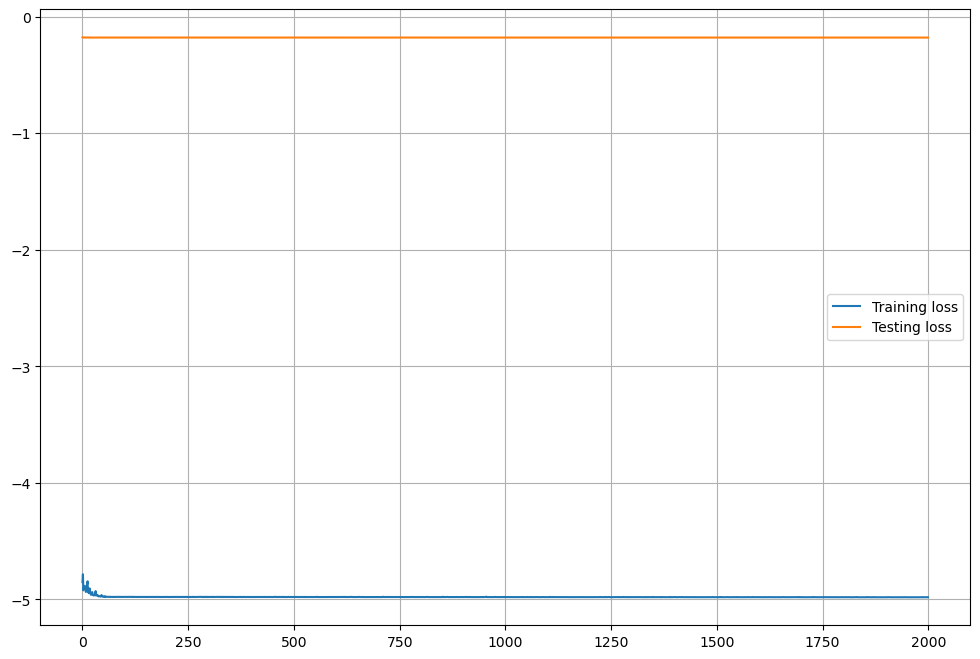

In [91]:
# plot loss_train and loss_test in log scale
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(np.log(loss_train_fine), label='Training loss')
plt.plot(np.log(loss_test_fine), label='Testing loss')
# add grid
plt.grid()
plt.legend()

/tmp/ipykernel_55273/2095710087.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)


0.15901982290011915


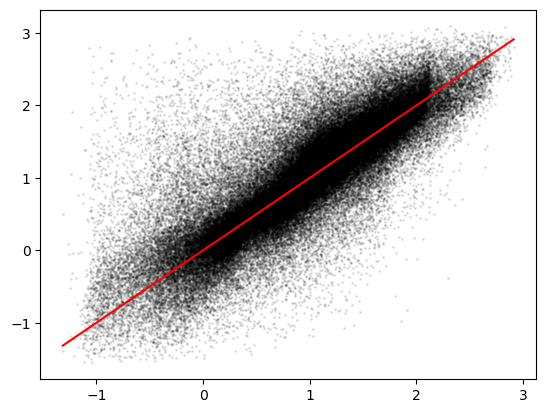

In [53]:
# Step 6: Test the Model
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()
from matplotlib import pyplot as plt
# plot line x=y from -40 to 100

for i in range(1):
    plt.plot([np.min(res_surr[:,i]), np.max(res_surr[:,i])], [np.min(res_surr[:,i]), np.max(res_surr[:,i])], 'r')
    plt.scatter(res_surr[:,i], y_test[:,i], alpha=0.1, s=1,c='k')
    print(np.sum((res_surr[:,i] - y_test[:,i].detach().cpu().numpy()) ** 2 ) / len(y_test[:,0]))
    plt.show()

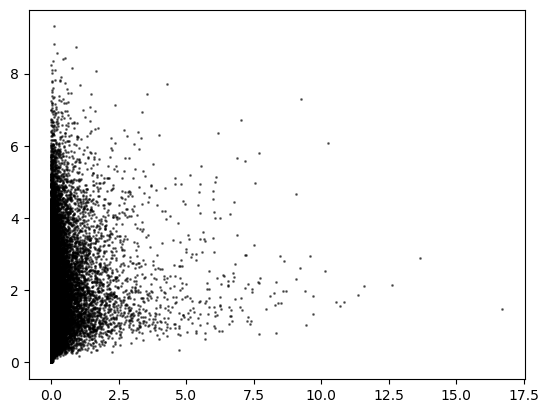

In [44]:
plt.scatter((res_surr[:,0] - y_test[:,0].detach().cpu().numpy())**2,np.sum(X_test_tensor.detach().cpu().numpy()**2,axis=1), alpha=0.5, s=1,c='k')

9.99544266093251e-07


/tmp/ipykernel_55273/4046298074.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)


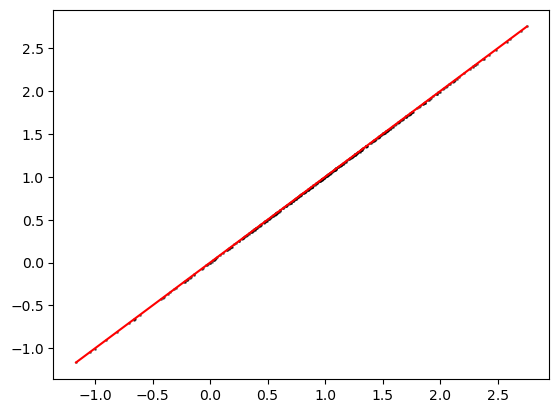

In [45]:
# Step 6: Test the Model
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
res_surr = model(X_train_tensor).detach().cpu().numpy()
for i in range(1):
    plt.plot([np.min(res_surr[:,i]), np.max(res_surr[:,i])], [np.min(res_surr[:,i]), np.max(res_surr[:,i])], 'r')
    plt.scatter(res_surr[:,i], y_train[:,i], alpha=0.5, s=1,c='k')
    print(np.sum((res_surr[:,i] - y_train[:,i].detach().cpu().numpy()) ** 2 ) / len(y_train[:,0]))
    plt.show()